# Estacionariedad general

In [10]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import os

class StationarityAnalyzer:
    """
    Clase para analizar la estacionariedad de modelos de series de tiempo
    """
    
    def __init__(self):
        self.results = []
        # Crear carpeta para guardar plots
        self.output_dir = "roots"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
    
    def check_ar_stationarity(self, phi_coeffs: List[float], model_name: str) -> Tuple[bool, List[complex], List[float]]:
        """
        Verifica estacionariedad para modelos AR(p)
        
        Args:
            phi_coeffs: Coeficientes phi del modelo AR [φ1, φ2, ..., φp]
            model_name: Nombre del modelo para reporte
            
        Returns:
            Tuple (es_estacionario, raices, modulos)
        """
        try:
            # Construir el polinomio característico: 1 - φ1*z - φ2*z^2 - ... - φp*z^p = 0
            # numpy.roots requiere coeficientes de MAYOR a MENOR grado
            # Para AR(p): 1 - φ1*z - φ2*z^2 - ... - φp*z^p
            # Coeficientes: [-φp, -φ(p-1), ..., -φ2, -φ1, 1]
            poly_coeffs = [-phi for phi in reversed(phi_coeffs)] + [1.0]
            
            # Encontrar las raíces
            roots = np.roots(poly_coeffs)
            
            # Calcular módulos
            moduli = np.abs(roots)
            
            # Verificar si todas las raíces están ESTRICTAMENTE fuera del círculo unitario
            # Usamos un pequeño epsilon para manejar errores numéricos
            epsilon = 1e-10
            is_stationary = all(mod > 1.0 + epsilon for mod in moduli)
            
            return is_stationary, roots, moduli
            
        except Exception as e:
            print(f"Error analizando {model_name}: {e}")
            return False, np.array([]), np.array([])
    
    def plot_single_model(self, result: Dict, filename: str):
        """
        Crear un plot individual para un modelo mostrando sus raíces y el círculo unitario
        
        Args:
            result: Diccionario con los resultados del modelo
            filename: Nombre del archivo para guardar el plot
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Recolectar todas las raíces para calcular límites dinámicos
        all_reals = []
        all_imags = []
        
        # Determinar el tipo de modelo
        if result['Escenario'] == 'No Lineal':
            # Para modelos no lineales, plotear ambos regímenes
            if len(result['Raices_Bajo']) > 0:
                real_bajo = [r.real for r in result['Raices_Bajo']]
                imag_bajo = [r.imag for r in result['Raices_Bajo']]
                ax.scatter(real_bajo, imag_bajo, s=100, marker='o', 
                          label='Régimen Bajo', alpha=0.7, edgecolors='black', linewidths=2)
                all_reals.extend(real_bajo)
                all_imags.extend(imag_bajo)
            
            if len(result['Raices_Alto']) > 0:
                real_alto = [r.real for r in result['Raices_Alto']]
                imag_alto = [r.imag for r in result['Raices_Alto']]
                ax.scatter(real_alto, imag_alto, s=100, marker='s', 
                          label='Régimen Alto', alpha=0.7, edgecolors='black', linewidths=2)
                all_reals.extend(real_alto)
                all_imags.extend(imag_alto)
        else:
            # Para modelos lineales
            if len(result['Raices']) > 0:
                real = [r.real for r in result['Raices']]
                imag = [r.imag for r in result['Raices']]
                ax.scatter(real, imag, s=100, marker='o', 
                          label='Raíces', alpha=0.7, edgecolors='black', linewidths=2)
                all_reals.extend(real)
                all_imags.extend(imag)
        
        # Dibujar círculo unitario
        theta = np.linspace(0, 2*np.pi, 200)
        ax.plot(np.cos(theta), np.sin(theta), 'r--', linewidth=2, label='Círculo Unitario')
        
        # Ejes
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.5)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=0.5)
        
        # Configuración del plot
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Parte Real', fontsize=12)
        ax.set_ylabel('Parte Imaginaria', fontsize=12)
        
        # Título con información de estacionariedad
        status_emoji = "✓" if result['Estacionario'] else "✗"
        title = f"{result['Modelo']} - {result['Status']}\n{status_emoji}"
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        ax.legend(loc='best', fontsize=10)
        
        # Ajustar límites dinámicamente basados en las raíces
        if all_reals and all_imags:
            max_real = max(abs(r) for r in all_reals)
            max_imag = max(abs(i) for i in all_imags)
            max_val = max(max_real, max_imag, 1.5)  # Al menos 1.5 para incluir el círculo unitario
            max_val = max_val * 1.2  # Agregar 20% de margen
        else:
            max_val = 2.5  # Valor por defecto si no hay raíces
        
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)
        
        plt.tight_layout()
        
        # Guardar el plot
        filepath = os.path.join(self.output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"  Plot guardado: {filepath}")
    
    def analyze_linear_stationary(self):
        """Analizar modelos del Escenario 1: Estacionario y Lineal"""
        print("=" * 60)
        print("ESCENARIO 1: ESTACIONARIO Y LINEAL")
        print("=" * 60)
        
        models = [
            {'name': 'AR(1)', 'phi': [0.9], 'theta': []},
            {'name': 'AR(2)', 'phi': [0.5, -0.3], 'theta': []},
            {'name': 'MA(1)', 'phi': [], 'theta': [0.7]},
            {'name': 'MA(2)', 'phi': [], 'theta': [0.4, 0.2]},
            {'name': 'ARMA(1,1)', 'phi': [0.6], 'theta': [0.3]},
            {'name': 'ARMA(2,2)', 'phi': [0.4, -0.2], 'theta': [0.5, 0.1]}
        ]
        
        for model in models:
            if model['phi']:  # Tiene componente AR
                stationary, roots, moduli = self.check_ar_stationarity(model['phi'], model['name'])
                status = "ESTACIONARIO" if stationary else "NO ESTACIONARIO"
            else:  # Modelo MA puro
                stationary = True
                roots, moduli = np.array([]), np.array([])
                status = "ESTACIONARIO (MA puro)"
            
            # Guardar resultados
            result = {
                'Escenario': 'Lineal Estacionario',
                'Modelo': model['name'],
                'Estacionario': stationary,
                'Status': status,
                'Raices': roots,
                'Modulos': moduli,
                'Coeficientes': model
            }
            self.results.append(result)
            
            # Mostrar resultados
            print(f"\n{model['name']}:")
            print(f"  Coeficientes φ: {model['phi']}, θ: {model['theta']}")
            print(f"  Status: {status}")
            if model['phi']:
                print(f"  Raíces: {roots}")
                print(f"  Módulos: {moduli}")
    
    def analyze_linear_nonstationary(self):
        """Analizar modelos del Escenario 2: No Estacionario y Lineal"""
        print("\n" + "=" * 60)
        print("ESCENARIO 2: NO ESTACIONARIO Y LINEAL")
        print("=" * 60)
        
        models = [
            {'name': 'ARIMA(0,1,0)', 'phi': [], 'theta': [], 'd': 1},
            {'name': 'ARIMA(1,1,0)', 'phi': [0.6], 'theta': [], 'd': 1},
            {'name': 'ARIMA(2,1,0)', 'phi': [0.5, -0.2], 'theta': [], 'd': 1},
            {'name': 'ARIMA(0,1,1)', 'phi': [], 'theta': [0.5], 'd': 1},
            {'name': 'ARIMA(0,1,2)', 'phi': [], 'theta': [0.4, 0.25], 'd': 1},
            {'name': 'ARIMA(1,1,1)', 'phi': [0.7], 'theta': [-0.3], 'd': 1},
            {'name': 'ARIMA(2,1,2)', 'phi': [0.6, 0.2], 'theta': [0.4, -0.1], 'd': 1}
        ]
        
        for model in models:
            # Modelos ARIMA con d>=1 siempre son no estacionarios
            stationary = False
            status = "NO ESTACIONARIO (ARIMA con d>=1)"
            
            # Aún así verificamos las raíces de la parte AR
            roots, moduli = np.array([]), np.array([])
            if model['phi']:
                stationary_ar, roots, moduli = self.check_ar_stationarity(model['phi'], model['name'])
                # Aunque la parte AR sea estacionaria, el modelo completo no lo es por la integración
            
            # Guardar resultados
            result = {
                'Escenario': 'Lineal No Estacionario',
                'Modelo': model['name'],
                'Estacionario': stationary,
                'Status': status,
                'Raices': roots,
                'Modulos': moduli,
                'Coeficientes': model
            }
            self.results.append(result)
            
            # Mostrar resultados
            print(f"\n{model['name']}:")
            print(f"  Coeficientes φ: {model['phi']}, θ: {model['theta']}, d: {model['d']}")
            print(f"  Status: {status}")
            if model['phi']:
                print(f"  Raíces parte AR: {roots}")
                print(f"  Módulos parte AR: {moduli}")
    
    def analyze_nonlinear(self):
        """Analizar modelos del Escenario 3: No Lineal"""
        print("\n" + "=" * 60)
        print("ESCENARIO 3: NO LINEAL")
        print("=" * 60)
        
        models = [
            {'name': 'SETAR(2,1)', 'phi_low': [0.6], 'phi_high': [-0.5], 'threshold': 0.0, 'delay': 1},
            {'name': 'SETAR(2,2)', 'phi_low': [0.5, -0.2], 'phi_high': [-0.3, 0.1], 'threshold': 0.5, 'delay': 1},
            {'name': 'TAR(2,1)', 'phi_low': [0.7], 'phi_high': [-0.7], 'threshold': 0.0, 'delay': 2},
            {'name': 'TAR(2,2)', 'phi_low': [0.3, 0.1], 'phi_high': [-0.2, -0.1], 'threshold': 1.0, 'delay': 1},
            {'name': 'EXPAR(2,1)', 'phi_low': [0.6], 'phi_high': [-0.4], 'threshold': 0.0, 'delay': 1},
            {'name': 'BILINEAR(1)', 'phi_low': [0.5], 'phi_high': [0.5], 'threshold': 0.0, 'delay': 1},
            {'name': 'SETAR(2,3)', 'phi_low': [0.4, -0.1, 0.05], 'phi_high': [-0.3, 0.1, -0.05], 'threshold': 0.0, 'delay': 1}
        ]
        
        for model in models:
            # Verificar ambos regímenes
            low_stationary, low_roots, low_moduli = self.check_ar_stationarity(
                model['phi_low'], f"{model['name']} (Régimen Bajo)")
            high_stationary, high_roots, high_moduli = self.check_ar_stationarity(
                model['phi_high'], f"{model['name']} (Régimen Alto)")
            
            # El modelo es estacionario si ambos regímenes lo son
            stationary = low_stationary and high_stationary
            status = "ESTACIONARIO" if stationary else "NO ESTACIONARIO"
            
            # Guardar resultados
            result = {
                'Escenario': 'No Lineal',
                'Modelo': model['name'],
                'Estacionario': stationary,
                'Status': status,
                'Raices_Bajo': low_roots,
                'Modulos_Bajo': low_moduli,
                'Raices_Alto': high_roots,
                'Modulos_Alto': high_moduli,
                'Raices': np.array([]),  # Para compatibilidad con plot_single_model
                'Modulos': np.array([]),
                'Coeficientes': model
            }
            self.results.append(result)
            
            # Mostrar resultados
            print(f"\n{model['name']}:")
            print(f"  φ_bajo: {model['phi_low']}, φ_alto: {model['phi_high']}")
            print(f"  Status: {status}")
            print(f"  Régimen bajo - Estacionario: {low_stationary}")
            if model['phi_low']:
                print(f"    Raíces: {low_roots}")
                print(f"    Módulos: {low_moduli}")
            print(f"  Régimen alto - Estacionario: {high_stationary}")
            if model['phi_high']:
                print(f"    Raíces: {high_roots}")
                print(f"    Módulos: {high_moduli}")
    
    def generate_summary_table(self) -> pd.DataFrame:
        """
        Generar tabla resumen con todos los modelos y su estacionariedad
        
        Returns:
            DataFrame con columnas: Modelo, Estacionario (Sí/No)
        """
        table_data = []
        
        for result in self.results:
            row = {
                'Modelo': result['Modelo'],
                'Estacionario': 'Sí' if result['Estacionario'] else 'No',
                'Escenario': result['Escenario']
            }
            table_data.append(row)
        
        df = pd.DataFrame(table_data)
        
        # Reordenar columnas
        df = df[['Modelo', 'Estacionario', 'Escenario']]
        
        return df
    
    def generate_all_plots(self):
        """
        Generar un plot individual para cada modelo analizado
        """
        print("\n" + "=" * 60)
        print("GENERANDO PLOTS INDIVIDUALES")
        print("=" * 60)
        
        for idx, result in enumerate(self.results, 1):
            # Crear nombre de archivo seguro
            safe_name = result['Modelo'].replace('(', '').replace(')', '').replace(',', '_').replace(' ', '_')
            filename = f"{idx:02d}_{safe_name}.png"
            
            print(f"\nGenerando plot {idx}/{len(self.results)}: {result['Modelo']}")
            self.plot_single_model(result, filename)
        
        print(f"\n✓ Todos los plots guardados en la carpeta '{self.output_dir}/'")
    
    def generate_summary(self):
        """Generar resumen de todos los análisis"""
        print("\n" + "=" * 80)
        print("RESUMEN GENERAL")
        print("=" * 80)
        
        df_data = []
        for result in self.results:
            row = {
                'Escenario': result['Escenario'],
                'Modelo': result['Modelo'],
                'Estacionario': result['Estacionario'],
                'Status': result['Status']
            }
            
            # Agregar información específica según el escenario
            if result['Escenario'] == 'No Lineal':
                epsilon = 1e-10
                row['Estacionario_Bajo'] = all(mod > 1.0 + epsilon for mod in result['Modulos_Bajo']) if len(result['Modulos_Bajo']) > 0 else True
                row['Estacionario_Alto'] = all(mod > 1.0 + epsilon for mod in result['Modulos_Alto']) if len(result['Modulos_Alto']) > 0 else True
            else:
                row['Min_Modulo'] = min(result['Modulos']) if len(result['Modulos']) > 0 else float('inf')
            
            df_data.append(row)
        
        df = pd.DataFrame(df_data)
        
        # Resumen por escenario
        print("\nDISTRIBUCIÓN POR ESCENARIO:")
        summary = df.groupby(['Escenario', 'Estacionario']).size().unstack(fill_value=0)
        print(summary)
        
        print("\nDETALLE COMPLETO:")
        for escenario in df['Escenario'].unique():
            print(f"\n{escenario}:")
            escenario_df = df[df['Escenario'] == escenario]
            for _, row in escenario_df.iterrows():
                status_color = "✓" if row['Estacionario'] else "✗"
                print(f"  {status_color} {row['Modelo']}: {row['Status']}")
    
    def run_complete_analysis(self) -> pd.DataFrame:
        """
        Ejecutar análisis completo
        
        Returns:
            DataFrame con tabla resumen de estacionariedad
        """
        # Realizar análisis
        self.analyze_linear_stationary()
        self.analyze_linear_nonstationary()
        self.analyze_nonlinear()
        self.generate_summary()
        
        # Generar tabla resumen
        print("\n" + "=" * 80)
        print("TABLA RESUMEN DE ESTACIONARIEDAD")
        print("=" * 80)
        summary_table = self.generate_summary_table()
        print("\n" + summary_table.to_string(index=False))
        
        # Guardar tabla en CSV
        csv_path = os.path.join(self.output_dir, "resumen_estacionariedad.csv")
        summary_table.to_csv(csv_path, index=False)
        print(f"\n✓ Tabla guardada en: {csv_path}")
        
        # Generar todos los plots
        self.generate_all_plots()
        
        print("\n" + "=" * 80)
        print("ANÁLISIS COMPLETADO")
        print("=" * 80)
        
        # Estadísticas finales
        total = len(self.results)
        estacionarios = sum(1 for r in self.results if r['Estacionario'])
        no_estacionarios = total - estacionarios
        
        print(f"\nESTADÍSTICAS FINALES:")
        print(f"Total de modelos analizados: {total}")
        print(f"Modelos estacionarios: {estacionarios} ({estacionarios/total*100:.1f}%)")
        print(f"Modelos no estacionarios: {no_estacionarios} ({no_estacionarios/total*100:.1f}%)")
        print(f"\nArchivos generados:")
        print(f"  - Tabla resumen: {csv_path}")
        print(f"  - Plots individuales: {total} archivos en carpeta '{self.output_dir}/'")
        
        return summary_table

# Ejecutar el análisis
if __name__ == "__main__":
    analyzer = StationarityAnalyzer()
    summary_df = analyzer.run_complete_analysis()
    
    print("\n" + "=" * 80)
    print("¡Análisis finalizado exitosamente!")
    print("=" * 80)

ESCENARIO 1: ESTACIONARIO Y LINEAL

AR(1):
  Coeficientes φ: [0.9], θ: []
  Status: ESTACIONARIO
  Raíces: [1.11111111]
  Módulos: [1.11111111]

AR(2):
  Coeficientes φ: [0.5, -0.3], θ: []
  Status: ESTACIONARIO
  Raíces: [0.83333333+1.62446572j 0.83333333-1.62446572j]
  Módulos: [1.82574186 1.82574186]

MA(1):
  Coeficientes φ: [], θ: [0.7]
  Status: ESTACIONARIO (MA puro)

MA(2):
  Coeficientes φ: [], θ: [0.4, 0.2]
  Status: ESTACIONARIO (MA puro)

ARMA(1,1):
  Coeficientes φ: [0.6], θ: [0.3]
  Status: ESTACIONARIO
  Raíces: [1.66666667]
  Módulos: [1.66666667]

ARMA(2,2):
  Coeficientes φ: [0.4, -0.2], θ: [0.5, 0.1]
  Status: ESTACIONARIO
  Raíces: [1.+2.j 1.-2.j]
  Módulos: [2.23606798 2.23606798]

ESCENARIO 2: NO ESTACIONARIO Y LINEAL

ARIMA(0,1,0):
  Coeficientes φ: [], θ: [], d: 1
  Status: NO ESTACIONARIO (ARIMA con d>=1)

ARIMA(1,1,0):
  Coeficientes φ: [0.6], θ: [], d: 1
  Status: NO ESTACIONARIO (ARIMA con d>=1)
  Raíces parte AR: [1.66666667]
  Módulos parte AR: [1.66666667

# No lineal - ADF

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class SETARStationarityAnalyzer:
    """
    Analiza la estacionariedad de modelos SETAR mediante múltiples pruebas.
    """
    
    def __init__(self, phi_low: List[float], phi_high: List[float], 
                 threshold: float = 0.0, delay: int = 1, 
                 sigma: float = 1.0, seed: int = 42,
                 model_type: str = "SETAR"):
        self.phi_low = np.array(phi_low)
        self.phi_high = np.array(phi_high)
        self.threshold = threshold
        self.delay = delay
        self.sigma = sigma
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.model_type = model_type
        
    def simulate_setar(self, n: int = 5000, burn_in: int = 1000) -> np.ndarray:
        """Simula una serie SETAR estándar."""
        total_length = n + burn_in
        p = max(len(self.phi_low), len(self.phi_high), self.delay)
        
        errors = self.rng.normal(0, self.sigma, total_length)
        series = np.zeros(total_length)
        series[:p] = self.rng.normal(0, self.sigma, p)
        
        for t in range(p, total_length):
            threshold_var = series[t - self.delay]
            regime = 1 if threshold_var > self.threshold else 0
            phi = self.phi_high if regime == 1 else self.phi_low
            
            ar_part = 0
            for lag in range(len(phi)):
                if t - lag - 1 >= 0:
                    ar_part += phi[lag] * series[t - lag - 1]
            
            series[t] = ar_part + errors[t]
        
        return series[burn_in:]
    
    def simulate_expar_stochastic(self, n: int = 5000, burn_in: int = 1000, 
                                   lambda_smooth: float = 10.0) -> np.ndarray:
        """
        Simula modelo SETAR Estocástico-1 (etiquetado como EXPAR(2,1)).
        Selección probabilística de régimen basada en función logística.
        """
        total_length = n + burn_in
        p = max(len(self.phi_low), len(self.phi_high), self.delay)
        
        errors = self.rng.normal(0, self.sigma, total_length)
        series = np.zeros(total_length)
        series[:p] = self.rng.normal(0, self.sigma, p)
        
        for t in range(p, total_length):
            threshold_var = series[t - self.delay]
            
            # Peso probabilístico con función logística
            w_t = 1 / (1 + np.exp(-lambda_smooth * (threshold_var - self.threshold)))
            
            # Selección estocástica del régimen
            regime = 1 if self.rng.random() < w_t else 0
            phi = self.phi_high if regime == 1 else self.phi_low
            
            ar_part = 0
            for lag in range(len(phi)):
                if t - lag - 1 >= 0:
                    ar_part += phi[lag] * series[t - lag - 1]
            
            series[t] = ar_part + errors[t]
        
        return series[burn_in:]
    
    def simulate_setar_bilinear(self, n: int = 5000, burn_in: int = 1000, 
                                beta: float = 0.3) -> np.ndarray:
        """
        Simula modelo SETAR-Bilinear-1 (etiquetado como BILINEAR(1)).
        Incluye término de interacción bilineal Y_{t-1}*ε_{t-1}.
        """
        total_length = n + burn_in
        p = max(len(self.phi_low), len(self.phi_high), self.delay)
        
        errors = self.rng.normal(0, self.sigma, total_length)
        series = np.zeros(total_length)
        series[:p] = self.rng.normal(0, self.sigma, p)
        
        for t in range(p, total_length):
            threshold_var = series[t - self.delay]
            regime = 1 if threshold_var > self.threshold else 0
            phi = self.phi_high if regime == 1 else self.phi_low
            
            # Parte AR
            ar_part = 0
            for lag in range(len(phi)):
                if t - lag - 1 >= 0:
                    ar_part += phi[lag] * series[t - lag - 1]
            
            # Término bilineal: β * Y_{t-1} * ε_{t-1}
            bilinear_term = 0
            if t >= 2:
                bilinear_term = beta * series[t - 1] * errors[t - 1]
            
            series[t] = ar_part + bilinear_term + errors[t]
        
        return series[burn_in:]
    
    def simulate(self, n: int = 5000, burn_in: int = 1000, **kwargs) -> np.ndarray:
        """Simula según el tipo de modelo."""
        if self.model_type == "EXPAR_STOCHASTIC":
            return self.simulate_expar_stochastic(n, burn_in, 
                                                  lambda_smooth=kwargs.get('lambda_smooth', 10.0))
        elif self.model_type == "SETAR_BILINEAR":
            return self.simulate_setar_bilinear(n, burn_in, 
                                                beta=kwargs.get('beta', 0.3))
        else:
            return self.simulate_setar(n, burn_in)
    
    def check_ar_stationarity(self, phi: np.ndarray) -> Dict:
        """Verifica condiciones de estacionariedad para un proceso AR(p)."""
        p = len(phi)
        
        if p == 1:
            stationary = abs(phi[0]) < 1
            return {
                'order': 1,
                'stationary': stationary,
                'coefficient': phi[0],
                'abs_coef': abs(phi[0]),
                'max_coef': abs(phi[0])
            }
        else:
            poly_coeffs = np.concatenate([[1], -phi])
            roots = np.roots(poly_coeffs)
            moduli = np.abs(roots)
            stationary = np.all(moduli > 1)
            sum_abs_phi = np.sum(np.abs(phi))
            
            return {
                'order': p,
                'stationary': stationary,
                'min_modulus': np.min(moduli),
                'sum_abs_coef': sum_abs_phi,
                'max_coef': np.max(np.abs(phi))
            }
    
    def check_setar_global_stationarity(self) -> Dict:
        """
        Verifica condiciones de estacionariedad global para SETAR.
        
        Condición suficiente (pero NO necesaria):
        - Ambos regímenes deben ser estacionarios
        
        NOTA: Un SETAR puede ser globalmente estacionario incluso si
        un régimen individualmente no lo es, debido al efecto estabilizador
        del cambio de régimen.
        """
        low_stat = self.check_ar_stationarity(self.phi_low)
        high_stat = self.check_ar_stationarity(self.phi_high)
        
        # Condición suficiente conservadora
        both_stationary = low_stat['stationary'] and high_stat['stationary']
        
        # Condición más relajada: al menos uno es fuertemente estacionario
        # y el otro no es explosivo
        max_low = low_stat['max_coef']
        max_high = high_stat['max_coef']
        
        relaxed_condition = (
            (low_stat['stationary'] and max_high < 0.95) or
            (high_stat['stationary'] and max_low < 0.95)
        )
        
        return {
            'both_regimes_stationary': both_stationary,
            'relaxed_condition': relaxed_condition,
            'theoretical_stationary': both_stationary,  # Mantener conservador
            'note': 'SETAR puede ser globalmente estacionario incluso sin cumplir condición individual'
        }
    
    def check_bilinear_stationarity(self, phi: float, beta: float, sigma2: float = 1.0) -> Dict:
        """
        Verifica estacionariedad de modelo bilinear: Y_t = φ*Y_{t-1} + β*Y_{t-1}*ε_{t-1} + ε_t
        Condición: |φ| + β²*σ² < 1
        """
        condition_value = abs(phi) + beta**2 * sigma2
        stationary = condition_value < 1
        
        return {
            'phi': phi,
            'beta': beta,
            'sigma2': sigma2,
            'condition_value': condition_value,
            'stationary': stationary
        }
    
    def statistical_tests(self, series: np.ndarray) -> Dict:
        """Aplica pruebas estadísticas de estacionariedad."""
        # CORRECCIÓN 1: Verificar que la serie no tenga valores infinitos o NaN
        if not np.all(np.isfinite(series)):
            print(f"  ⚠️  Serie contiene valores no finitos!")
            return {
                'adf_stationary': False,
                'adf_pvalue': np.nan,
                'adf_statistic': np.nan,
                'kpss_stationary': False,
                'kpss_pvalue': np.nan,
                'kpss_statistic': np.nan,
                'both_agree': False
            }
        
        # CORRECCIÓN 2: Verificar que la serie tenga varianza
        if np.std(series) < 1e-10:
            print(f"  ⚠️  Serie tiene varianza casi nula!")
            return {
                'adf_stationary': False,
                'adf_pvalue': np.nan,
                'adf_statistic': np.nan,
                'kpss_stationary': False,
                'kpss_pvalue': np.nan,
                'kpss_statistic': np.nan,
                'both_agree': False
            }
        
        # ADF Test con manejo mejorado
        try:
            # CORRECCIÓN 3: Usar maxlag más conservador y regression='c'
            adf_result = adfuller(series, maxlag=int(12*(len(series)/100)**(1/4)), 
                                 regression='c', autolag='AIC')
            adf_statistic = float(adf_result[0])
            adf_pvalue = float(adf_result[1])
            
            # CORRECCIÓN 4: Verificar si el p-valor es realmente 0 o muy pequeño
            if adf_pvalue == 0.0:
                # El p-valor puede ser menor que la precisión de máquina
                # pero debemos reportarlo como "< 0.01" no como "0"
                print(f"  ℹ️  ADF p-value reportado como 0.0 (muy pequeño)")
                adf_pvalue = 0.0  # Mantener como 0.0 pero con advertencia
            
            adf_stationary = adf_pvalue < 0.05
            
        except Exception as e:
            print(f"  ⚠️  Error en ADF: {e}")
            adf_stationary = False
            adf_pvalue = np.nan
            adf_statistic = np.nan
        
        # KPSS Test
        try:
            kpss_result = kpss(series, regression='c', nlags='auto')
            kpss_statistic = float(kpss_result[0])
            kpss_pvalue = float(kpss_result[1])
            kpss_stationary = kpss_pvalue > 0.05
        except Exception as e:
            print(f"  ⚠️  Error en KPSS: {e}")
            kpss_stationary = False
            kpss_pvalue = np.nan
            kpss_statistic = np.nan
        
        return {
            'adf_stationary': adf_stationary,
            'adf_pvalue': adf_pvalue,
            'adf_statistic': adf_statistic,
            'kpss_stationary': kpss_stationary,
            'kpss_pvalue': kpss_pvalue,
            'kpss_statistic': kpss_statistic,
            'both_agree': adf_stationary and kpss_stationary
        }
    
    def moment_analysis(self, n_simulations: int = 50, n_points: int = 2000, **kwargs) -> Dict:
        """Analiza estabilidad de momentos mediante múltiples simulaciones."""
        means = []
        variances = []
        
        for _ in range(n_simulations):
            series = self.simulate(n=n_points, burn_in=500, **kwargs)
            means.append(np.mean(series))
            variances.append(np.var(series))
        
        means = np.array(means)
        variances = np.array(variances)
        
        cv_mean = np.std(means) / (np.abs(np.mean(means)) + 1e-10)
        cv_var = np.std(variances) / (np.mean(variances) + 1e-10)
        
        mean_stable = cv_mean < 0.5
        var_stable = cv_var < 0.5
        
        return {
            'mean_avg': np.mean(means),
            'mean_cv': cv_mean,
            'mean_stable': mean_stable,
            'var_avg': np.mean(variances),
            'var_cv': cv_var,
            'var_stable': var_stable,
            'moments_stable': mean_stable and var_stable
        }
    
    def ergodicity_test(self, n_realizations: int = 30, n_points: int = 1000, **kwargs) -> Dict:
        """Test de ergodicidad: compara promedio temporal vs promedio de ensemble."""
        long_series = self.simulate(n=n_points * 10, burn_in=1000, **kwargs)
        time_average = np.mean(long_series)
        
        ensemble_means = []
        for _ in range(n_realizations):
            series = self.simulate(n=n_points, burn_in=500, **kwargs)
            ensemble_means.append(np.mean(series))
        
        ensemble_average = np.mean(ensemble_means)
        mean_diff = abs(time_average - ensemble_average)
        mean_ergodic = mean_diff < 0.5 * (abs(time_average) + 0.1)
        
        return {
            'time_average': time_average,
            'ensemble_average': ensemble_average,
            'mean_difference': mean_diff,
            'ergodic': mean_ergodic
        }
    
    def full_analysis(self, **kwargs) -> Dict:
        """Análisis completo de estacionariedad."""
        print(f"\nAnalizando: {kwargs.get('name', 'Modelo')}...")
        
        # 1. Condiciones teóricas
        low_result = self.check_ar_stationarity(self.phi_low)
        high_result = self.check_ar_stationarity(self.phi_high)
        
        # Para modelo bilinear, verificar condición adicional
        if self.model_type == "SETAR_BILINEAR":
            beta = kwargs.get('beta', 0.3)
            bilinear_check = self.check_bilinear_stationarity(
                self.phi_low[0], beta, self.sigma**2
            )
            theory_stationary = bilinear_check['stationary']
        else:
            theory_stationary = low_result['stationary'] and high_result['stationary']
        
        # 2. Simulación y pruebas
        series = self.simulate(n=5000, burn_in=1000, **kwargs)
        
        # DIAGNÓSTICO: Imprimir estadísticas de la serie
        print(f"  Serie: n={len(series)}, mean={np.mean(series):.4f}, std={np.std(series):.4f}")
        print(f"  Min={np.min(series):.4f}, Max={np.max(series):.4f}")
        
        stat_tests = self.statistical_tests(series)
        moments = self.moment_analysis(n_simulations=50, n_points=2000, **kwargs)
        ergodic = self.ergodicity_test(n_realizations=30, n_points=1000, **kwargs)
        
        # Criterios
        all_criteria = [
            theory_stationary,
            stat_tests['adf_stationary'],
            stat_tests['kpss_stationary'],
            moments['moments_stable'],
            ergodic['ergodic']
        ]
        
        passed = sum(all_criteria)
        total = len(all_criteria)
        overall = passed >= 3
        
        return {
            'model_type': self.model_type,
            'theoretical': {
                'low': low_result, 
                'high': high_result, 
                'overall': theory_stationary
            },
            'statistical': stat_tests,
            'moments': moments,
            'ergodicity': ergodic,
            'series': series,
            'criteria_passed': passed,
            'criteria_total': total,
            'stationary': overall,
            'bilinear_check': kwargs.get('beta') if self.model_type == "SETAR_BILINEAR" else None
        }


def analyze_all_models():
    """Analiza todos los modelos SETAR y guarda resultados en Excel."""
    
    print("\n" + "="*80)
    print("ANÁLISIS DE ESTACIONARIEDAD - MODELOS SETAR (VERSIÓN CORREGIDA)")
    print("="*80)
    
    models = [
        {
            'name': 'SETAR-1',
            'phi_low': [0.6],
            'phi_high': [-0.5],
            'threshold': 0.0,
            'delay': 1,
            'model_type': 'SETAR'
        },
        {
            'name': 'SETAR-2',
            'phi_low': [0.5, -0.2],
            'phi_high': [-0.3, 0.1],
            'threshold': 0.5,
            'delay': 1,
            'model_type': 'SETAR'
        },
        {
            'name': 'SETAR-3',
            'phi_low': [0.4, -0.1, 0.05],
            'phi_high': [-0.3, 0.1, -0.05],
            'threshold': 0.0,
            'delay': 1,
            'model_type': 'SETAR'
        },
        {
            'name': 'SETAR-4',
            'phi_low': [0.7],
            'phi_high': [-0.7],
            'threshold': 0.0,
            'delay': 2,
            'model_type': 'SETAR'
        },
        {
            'name': 'SETAR-5',
            'phi_low': [0.3, 0.1],
            'phi_high': [-0.2, -0.1],
            'threshold': 1.0,
            'delay': 1,
            'model_type': 'SETAR'
        },
        {
            'name': 'EXPAR-Stochastic-1',
            'phi_low': [0.6],
            'phi_high': [-0.4],
            'threshold': 0.0,
            'delay': 1,
            'model_type': 'EXPAR_STOCHASTIC',
            'lambda_smooth': 10.0
        },
        {
            'name': 'SETAR-Bilinear-1',
            'phi_low': [0.5],
            'phi_high': [0.5],
            'threshold': 0.0,
            'delay': 1,
            'model_type': 'SETAR_BILINEAR',
            'beta': 0.3
        }
    ]
    
    results_list = []
    detailed_results = []
    
    for model_params in models:
        name = model_params.pop('name')
        model_type = model_params.get('model_type', 'SETAR')
        
        analyzer = SETARStationarityAnalyzer(
            phi_low=model_params['phi_low'],
            phi_high=model_params['phi_high'],
            threshold=model_params['threshold'],
            delay=model_params['delay'],
            sigma=1.0,
            seed=42,
            model_type=model_type
        )
        
        kwargs = {'name': name}
        if 'lambda_smooth' in model_params:
            kwargs['lambda_smooth'] = model_params['lambda_smooth']
        if 'beta' in model_params:
            kwargs['beta'] = model_params['beta']
        
        results = analyzer.full_analysis(**kwargs)
        
        # CORRECCIÓN 5: Formato mejorado para p-valores
        adf_pval_str = 'NaN' if np.isnan(results['statistical']['adf_pvalue']) else \
                       f"{results['statistical']['adf_pvalue']:.6e}" if results['statistical']['adf_pvalue'] < 0.0001 else \
                       f"{results['statistical']['adf_pvalue']:.6f}"
        
        kpss_pval_str = 'NaN' if np.isnan(results['statistical']['kpss_pvalue']) else \
                        f"{results['statistical']['kpss_pvalue']:.6f}"
        
        results_list.append({
            'Modelo': name,
            'Tipo': model_type,
            'φ_low': str(model_params['phi_low']),
            'φ_high': str(model_params['phi_high']),
            'Umbral': model_params['threshold'],
            'Retardo': model_params['delay'],
            'Teoría': '✓' if results['theoretical']['overall'] else '✗',
            'ADF': '✓' if results['statistical']['adf_stationary'] else '✗',
            'ADF_pval': adf_pval_str,
            'KPSS': '✓' if results['statistical']['kpss_stationary'] else '✗',
            'KPSS_pval': kpss_pval_str,
            'Momentos': '✓' if results['moments']['moments_stable'] else '✗',
            'Ergodicidad': '✓' if results['ergodicity']['ergodic'] else '✗',
            'Score': f"{results['criteria_passed']}/{results['criteria_total']}",
            'Estacionario': 'SÍ' if results['stationary'] else 'NO'
        })
        
        low = results['theoretical']['low']
        high = results['theoretical']['high']
        
        detailed_results.append({
            'Modelo': name,
            'Tipo': model_type,
            'Régimen': 'Bajo',
            'Coeficientes': str(model_params['phi_low']),
            'Orden': low['order'],
            'Max |φ|': low['max_coef'],
            'Estacionario_Régimen': 'SÍ' if low['stationary'] else 'NO',
            'Media': results['moments']['mean_avg'],
            'Varianza': results['moments']['var_avg'],
            'CV_Media': results['moments']['mean_cv'],
            'CV_Varianza': results['moments']['var_cv'],
            'ADF_pvalue': adf_pval_str,
            'KPSS_pvalue': kpss_pval_str,
            'Beta': kwargs.get('beta', '-'),
            'Lambda': kwargs.get('lambda_smooth', '-')
        })
        
        detailed_results.append({
            'Modelo': name,
            'Tipo': model_type,
            'Régimen': 'Alto',
            'Coeficientes': str(model_params['phi_high']),
            'Orden': high['order'],
            'Max |φ|': high['max_coef'],
            'Estacionario_Régimen': 'SÍ' if high['stationary'] else 'NO',
            'Media': '-', 'Varianza': '-', 'CV_Media': '-', 'CV_Varianza': '-',
            'ADF_pvalue': '-', 'KPSS_pvalue': '-', 'Beta': '-', 'Lambda': '-'
        })
    
    df_summary = pd.DataFrame(results_list)
    df_detailed = pd.DataFrame(detailed_results)
    
    output_file = 'analisis_estacionariedad_setar_corregido.xlsx'
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        df_summary.to_excel(writer, sheet_name='Resumen', index=False)
        df_detailed.to_excel(writer, sheet_name='Detalles por Régimen', index=False)
    
    print(f"\n✓ Resultados guardados en: {output_file}")
    print("\n" + "="*80)
    print("RESUMEN GENERAL")
    print("="*80)
    print(df_summary.to_string(index=False))

    print("\n" + "="*80)
    print("RESULTADOS DETALLADOS (INCLUYE P-VALUES)")
    print("="*80)
    print(df_detailed.to_string(index=False))
    
    stationary_count = df_summary[df_summary['Estacionario'] == 'SÍ'].shape[0]
    total_models = len(models)
    
    print(f"\n{'='*80}")
    print(f"Modelos estacionarios: {stationary_count}/{total_models}")
    print(f"{'='*80}\n")
    
    return df_summary, df_detailed


# Ejecutar análisis
if __name__ == "__main__":
    df_summary, df_detailed = analyze_all_models()


ANÁLISIS DE ESTACIONARIEDAD - MODELOS SETAR (VERSIÓN CORREGIDA)

Analizando: SETAR-1...
  Serie: n=5000, mean=-0.5794, std=1.1098
  Min=-4.5510, Max=3.2455
  ℹ️  ADF p-value reportado como 0.0 (muy pequeño)

Analizando: SETAR-2...
  Serie: n=5000, mean=-0.3047, std=1.0815
  Min=-4.5708, Max=3.4977
  ℹ️  ADF p-value reportado como 0.0 (muy pequeño)

Analizando: SETAR-3...
  Serie: n=5000, mean=-0.3076, std=1.0437
  Min=-4.2610, Max=3.4173
  ℹ️  ADF p-value reportado como 0.0 (muy pequeño)

Analizando: SETAR-4...
  Serie: n=5000, mean=-0.0054, std=1.3994
  Min=-5.4494, Max=5.3339
  ℹ️  ADF p-value reportado como 0.0 (muy pequeño)

Analizando: SETAR-5...
  Serie: n=5000, mean=-0.1687, std=1.0458
  Min=-4.1369, Max=3.5231
  ℹ️  ADF p-value reportado como 0.0 (muy pequeño)

Analizando: EXPAR-Stochastic-1...
  Serie: n=5000, mean=-0.5433, std=1.1113
  Min=-4.5491, Max=3.2514
  ℹ️  ADF p-value reportado como 0.0 (muy pequeño)

Analizando: SETAR-Bilinear-1...
  Serie: n=5000, mean=0.5952, std

# No Lineal - Paper


                  ANÁLISIS DE ESTACIONARIEDAD - MODELOS SETAR                   
                  Criterio del Radio Espectral Conjunto (JSR)                   

Analizando modelos SETAR deterministas...

Modelo: SETAR-1 | JSR: [0.6000, 0.5937] | Estacionario: SÍ

Modelo: SETAR-2 | JSR: [0.5000, 0.5839] | Estacionario: SÍ

Modelo: SETAR-3 | JSR: [0.6032, 0.6447] | Estacionario: SÍ

Modelo: SETAR-4 | JSR: [0.7000, 0.7000] | Estacionario: SÍ

Modelo: SETAR-5 | JSR: [0.5000, 1.0444] | Estacionario: NO

Analizando modelos SETAR especiales...

Modelo: SETAR-Estoc | JSR: [0.6000, 0.6000] | Estacionario: SÍ

Modelo: SETAR-Bilin | JSR: [0.5000, 0.5000] | Estacionario: SÍ

Analizando ejemplos de la literatura...

Modelo: Hansen-GNP | JSR: [0.9462, 1.0280] | Estacionario: NO

Modelo: Lynx-Data | JSR: [0.9908, 2.0514] | Estacionario: NO

                             EXPORTANDO RESULTADOS                              


✅ Resultados exportados exitosamente a: setar_analysis_results.xlsx
   Hojas

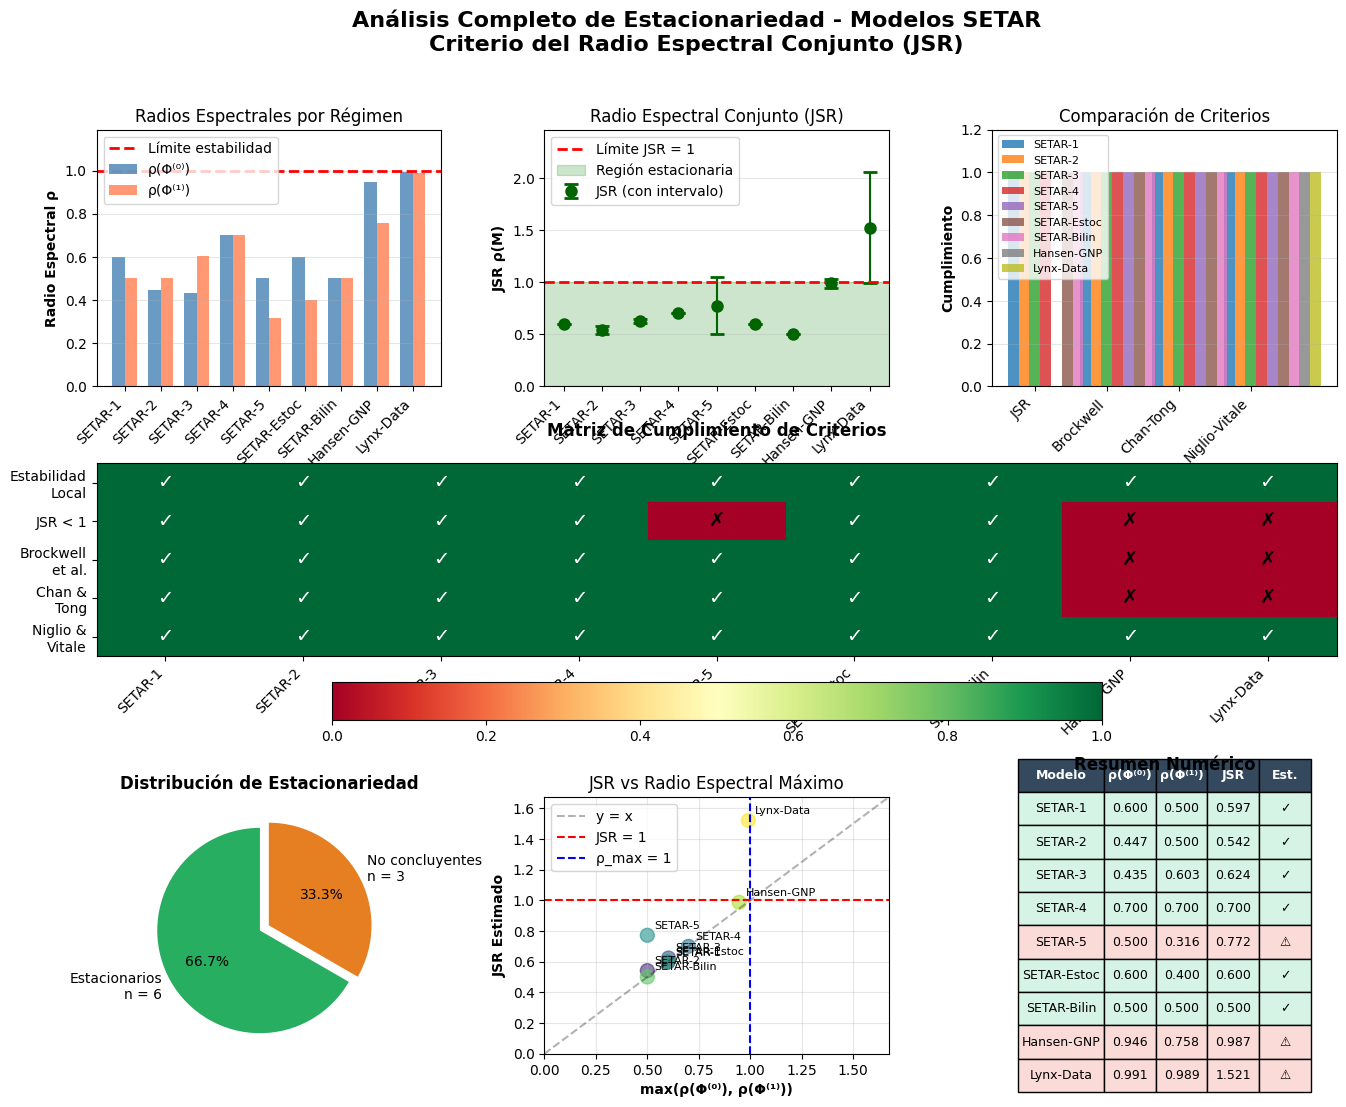


                                 RESUMEN FINAL                                  

    Total de modelos analizados:        9
    Modelos estacionarios (JSR < 1):    6 (66.7%)
    Modelos con estabilidad local:      9 (100.0%)
    
    Archivos generados:
    ✓ setar_analysis_results.xlsx  (Resultados completos en Excel)
    ✓ setar_stability_analysis.png  (Visualizaciones)
    
    Nota: JSR < 1 es condición SUFICIENTE pero NO NECESARIA para estacionariedad
    

✅ Análisis completo finalizado



In [3]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

class SETARStabilityAnalyzer:
    """
    Analizador de estabilidad para modelos SETAR usando el criterio del 
    Radio Espectral Conjunto (Joint Spectral Radius - JSR)
    
    Basado en Chen et al. (2023) - "Stability in Threshold VAR Models"
    """
    
    def __init__(self):
        self.results = {}
    
    def create_companion_matrix(self, phi: np.ndarray) -> np.ndarray:
        """Crea la matriz compañera para un proceso AR(p)"""
        phi = np.atleast_1d(phi)
        p = len(phi)
        
        if p == 1:
            return np.array([[phi[0]]])
        
        companion = np.zeros((p, p))
        companion[0, :] = phi
        companion[1:, :-1] = np.eye(p - 1)
        
        return companion
    
    def spectral_radius(self, matrix: np.ndarray) -> float:
        """Calcula el radio espectral de una matriz"""
        eigenvalues = linalg.eigvals(matrix)
        return np.max(np.abs(eigenvalues))
    
    def compute_jsr_approximation(self, 
                                   matrices: List[np.ndarray], 
                                   max_k: int = 12,
                                   num_samples: int = 2000) -> Tuple[float, float]:
        """Aproxima el JSR usando muestreo de productos matriciales"""
        n_matrices = len(matrices)
        dim = matrices[0].shape[0]
        
        # Cota inferior
        lower_bound = max(self.spectral_radius(M) for M in matrices)
        
        # Cota superior
        max_norm_per_k = []
        
        for k in range(1, max_k + 1):
            max_norm_k = 0
            
            if k <= 3:
                num_combinations = n_matrices ** k
                for idx in range(num_combinations):
                    temp_idx = idx
                    indices = []
                    for _ in range(k):
                        indices.append(temp_idx % n_matrices)
                        temp_idx //= n_matrices
                    
                    product = np.eye(dim)
                    for i in indices:
                        product = matrices[i] @ product
                    
                    norm = linalg.norm(product, ord=2)
                    norm_normalized = norm ** (1/k)
                    max_norm_k = max(max_norm_k, norm_normalized)
            else:
                for _ in range(num_samples):
                    indices = np.random.randint(0, n_matrices, size=k)
                    
                    product = np.eye(dim)
                    for idx in indices:
                        product = matrices[idx] @ product
                    
                    norm = linalg.norm(product, ord=2)
                    norm_normalized = norm ** (1/k)
                    max_norm_k = max(max_norm_k, norm_normalized)
            
            max_norm_per_k.append(max_norm_k)
        
        upper_bound = max(max_norm_per_k)
        
        if len(max_norm_per_k) >= 5:
            recent_values = max_norm_per_k[-3:]
            if max(recent_values) - min(recent_values) < 0.01:
                upper_bound = np.mean(recent_values)
        
        return lower_bound, upper_bound
    
    def brockwell_criterion(self, matrices: List[np.ndarray]) -> Tuple[bool, float]:
        """Criterio de Brockwell, Liu y Tweedie (1992)"""
        max_spectral_radius = max(self.spectral_radius(np.abs(M)) for M in matrices)
        return max_spectral_radius < 1, max_spectral_radius
    
    def chan_tong_criterion(self, phi_low: np.ndarray, phi_high: np.ndarray) -> Tuple[bool, float]:
        """Criterio de Chan y Tong (1985)"""
        sum_low = np.sum(np.abs(phi_low))
        sum_high = np.sum(np.abs(phi_high))
        max_sum = max(sum_low, sum_high)
        return max_sum < 1, max_sum
    
    def niglio_vitale_criterion(self, rho_0: float, rho_1: float, 
                                pi_0: float = 0.5, pi_1: float = 0.5) -> Tuple[bool, float]:
        """Criterio de Niglio y Vitale (2015)"""
        criterion_value = (rho_0 ** pi_0) * (rho_1 ** pi_1)
        return criterion_value < 1, criterion_value
    
    def analyze_characteristic_polynomial(self, phi: np.ndarray) -> Dict:
        """Analiza el polinomio característico del proceso AR"""
        p = len(phi)
        poly_coeffs = np.concatenate([[1], -phi])
        roots = np.roots(poly_coeffs)
        spectral_radius = np.max(np.abs(roots))
        
        return {
            'polynomial_coeffs': poly_coeffs,
            'roots': roots,
            'spectral_radius': spectral_radius,
            'is_stable': spectral_radius < 1.0
        }
    
    def analyze_setar_model(self, 
                           name: str,
                           phi_low: np.ndarray, 
                           phi_high: np.ndarray,
                           threshold: float,
                           delay: int,
                           verbose: bool = False) -> Dict:
        """Análisis completo de estacionariedad de un modelo SETAR"""
        phi_low = np.atleast_1d(phi_low)
        phi_high = np.atleast_1d(phi_high)
        
        # Crear matrices compañeras
        Phi_0 = self.create_companion_matrix(phi_low)
        Phi_1 = self.create_companion_matrix(phi_high)
        
        # Análisis de polinomios característicos
        poly_low = self.analyze_characteristic_polynomial(phi_low)
        poly_high = self.analyze_characteristic_polynomial(phi_high)
        
        # Radios espectrales individuales
        rho_0 = self.spectral_radius(Phi_0)
        rho_1 = self.spectral_radius(Phi_1)
        
        # JSR aproximado
        jsr_lower, jsr_upper = self.compute_jsr_approximation([Phi_0, Phi_1])
        
        # Criterios adicionales
        brockwell_ok, brockwell_val = self.brockwell_criterion([Phi_0, Phi_1])
        chan_tong_ok, chan_tong_val = self.chan_tong_criterion(phi_low, phi_high)
        niglio_ok, niglio_val = self.niglio_vitale_criterion(rho_0, rho_1)
        
        # Determinación de estacionariedad según JSR
        is_stationary_jsr = jsr_upper < 1.0
        is_conclusive = jsr_lower > 1.0 or jsr_upper < 1.0
        
        results = {
            'name': name,
            'phi_low': phi_low,
            'phi_high': phi_high,
            'threshold': threshold,
            'delay': delay,
            'order': len(phi_low),
            'Phi_0': Phi_0,
            'Phi_1': Phi_1,
            'poly_low': poly_low,
            'poly_high': poly_high,
            'rho_0': rho_0,
            'rho_1': rho_1,
            'jsr_lower': jsr_lower,
            'jsr_upper': jsr_upper,
            'jsr_estimate': (jsr_lower + jsr_upper) / 2,
            'is_stationary_jsr': is_stationary_jsr,
            'is_conclusive': is_conclusive,
            'brockwell_satisfied': brockwell_ok,
            'brockwell_value': brockwell_val,
            'chan_tong_satisfied': chan_tong_ok,
            'chan_tong_value': chan_tong_val,
            'niglio_vitale_satisfied': niglio_ok,
            'niglio_vitale_value': niglio_val,
            'locally_stable': (rho_0 < 1.0) and (rho_1 < 1.0),
            'confidence': 'Alta' if is_conclusive else 'Media'
        }
        
        self.results[name] = results
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"Modelo: {name} | JSR: [{jsr_lower:.4f}, {jsr_upper:.4f}] | Estacionario: {'SÍ' if is_stationary_jsr else 'NO'}")
            print(f"{'='*80}")
        
        return results
    
    def export_to_excel(self, filename: str = 'setar_analysis_results.xlsx'):
        """Exporta todos los resultados a un archivo Excel con múltiples hojas"""
        
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # ===================================================================
            # HOJA 1: RESUMEN GENERAL
            # ===================================================================
            summary_data = []
            for model_name, r in self.results.items():
                summary_data.append({
                    'Modelo': model_name,
                    'Tipo': self._get_model_type(model_name),
                    'Orden AR': f"AR({r['order']})",
                    'Umbral γ': r['threshold'],
                    'Retardo d': r['delay'],
                    'ρ(Φ⁽⁰⁾)': round(r['rho_0'], 6),
                    'ρ(Φ⁽¹⁾)': round(r['rho_1'], 6),
                    'JSR Inferior': round(r['jsr_lower'], 6),
                    'JSR Superior': round(r['jsr_upper'], 6),
                    'JSR Estimado': round(r['jsr_estimate'], 6),
                    'Estable Local': 'SÍ' if r['locally_stable'] else 'NO',
                    'Estacionario (JSR)': 'SÍ' if r['is_stationary_jsr'] else 'NO',
                    'Confianza': r['confidence']
                })
            
            df_summary = pd.DataFrame(summary_data)
            df_summary.to_excel(writer, sheet_name='Resumen General', index=False)
            
            # ===================================================================
            # HOJA 2: CRITERIOS DE ESTACIONARIEDAD
            # ===================================================================
            criteria_data = []
            for model_name, r in self.results.items():
                criteria_data.append({
                    'Modelo': model_name,
                    'JSR < 1': 'CUMPLE' if r['is_stationary_jsr'] else 'NO CUMPLE',
                    'JSR Valor': round(r['jsr_estimate'], 6),
                    'Brockwell et al.': 'CUMPLE' if r['brockwell_satisfied'] else 'NO CUMPLE',
                    'Brockwell Valor': round(r['brockwell_value'], 6),
                    'Chan & Tong': 'CUMPLE' if r['chan_tong_satisfied'] else 'NO CUMPLE',
                    'Chan & Tong Valor': round(r['chan_tong_value'], 6),
                    'Niglio & Vitale': 'CUMPLE' if r['niglio_vitale_satisfied'] else 'NO CUMPLE',
                    'Niglio & Vitale Valor': round(r['niglio_vitale_value'], 6),
                })
            
            df_criteria = pd.DataFrame(criteria_data)
            df_criteria.to_excel(writer, sheet_name='Criterios Estacionariedad', index=False)
            
            # ===================================================================
            # HOJA 3: COEFICIENTES AR
            # ===================================================================
            coef_data = []
            for model_name, r in self.results.items():
                phi_low_str = ', '.join([f"{x:.4f}" for x in r['phi_low']])
                phi_high_str = ', '.join([f"{x:.4f}" for x in r['phi_high']])
                
                coef_data.append({
                    'Modelo': model_name,
                    'Coeficientes Régimen Bajo (φ⁽⁰⁾)': phi_low_str,
                    'Coeficientes Régimen Alto (φ⁽¹⁾)': phi_high_str,
                    'Orden p': r['order'],
                })
            
            df_coef = pd.DataFrame(coef_data)
            df_coef.to_excel(writer, sheet_name='Coeficientes AR', index=False)
            
            # ===================================================================
            # HOJA 4: RAÍCES CARACTERÍSTICAS
            # ===================================================================
            roots_data = []
            for model_name, r in self.results.items():
                # Régimen bajo
                roots_low = r['poly_low']['roots']
                for i, root in enumerate(roots_low):
                    roots_data.append({
                        'Modelo': model_name,
                        'Régimen': 'Bajo',
                        'Raíz #': i + 1,
                        'Parte Real': round(np.real(root), 6),
                        'Parte Imaginaria': round(np.imag(root), 6),
                        'Módulo': round(np.abs(root), 6),
                    })
                
                # Régimen alto
                roots_high = r['poly_high']['roots']
                for i, root in enumerate(roots_high):
                    roots_data.append({
                        'Modelo': model_name,
                        'Régimen': 'Alto',
                        'Raíz #': i + 1,
                        'Parte Real': round(np.real(root), 6),
                        'Parte Imaginaria': round(np.imag(root), 6),
                        'Módulo': round(np.abs(root), 6),
                    })
            
            df_roots = pd.DataFrame(roots_data)
            df_roots.to_excel(writer, sheet_name='Raíces Características', index=False)
            
            # ===================================================================
            # HOJA 5: MATRICES COMPAÑERAS
            # ===================================================================
            matrices_data = []
            for model_name, r in self.results.items():
                # Matriz régimen bajo
                Phi_0 = r['Phi_0']
                n_rows, n_cols = Phi_0.shape
                
                for i in range(n_rows):
                    row_dict = {
                        'Modelo': model_name if i == 0 else '',
                        'Régimen': 'Bajo' if i == 0 else '',
                        'Fila': i + 1,
                    }
                    for j in range(n_cols):
                        row_dict[f'Col {j+1}'] = round(Phi_0[i, j], 6)
                    matrices_data.append(row_dict)
                
                # Matriz régimen alto
                Phi_1 = r['Phi_1']
                for i in range(n_rows):
                    row_dict = {
                        'Modelo': model_name if i == 0 else '',
                        'Régimen': 'Alto' if i == 0 else '',
                        'Fila': i + 1,
                    }
                    for j in range(n_cols):
                        row_dict[f'Col {j+1}'] = round(Phi_1[i, j], 6)
                    matrices_data.append(row_dict)
            
            df_matrices = pd.DataFrame(matrices_data)
            df_matrices.to_excel(writer, sheet_name='Matrices Compañeras', index=False)
            
            # ===================================================================
            # HOJA 6: RESUMEN ESTADÍSTICO
            # ===================================================================
            total = len(self.results)
            stationary = sum(1 for r in self.results.values() if r['is_stationary_jsr'])
            locally_stable = sum(1 for r in self.results.values() if r['locally_stable'])
            
            stats_data = [
                {'Métrica': 'Total de Modelos Analizados', 'Valor': total},
                {'Métrica': 'Modelos Estacionarios (JSR < 1)', 'Valor': stationary},
                {'Métrica': 'Porcentaje Estacionarios', 'Valor': f"{stationary/total*100:.1f}%"},
                {'Métrica': 'Modelos con Estabilidad Local', 'Valor': locally_stable},
                {'Métrica': 'Porcentaje Estabilidad Local', 'Valor': f"{locally_stable/total*100:.1f}%"},
                {'Métrica': '', 'Valor': ''},
                {'Métrica': 'Criterio Utilizado', 'Valor': 'Radio Espectral Conjunto (JSR)'},
                {'Métrica': 'Referencia Teórica', 'Valor': 'Chen et al. (2023) - Teorema 4.4'},
                {'Métrica': 'Condición', 'Valor': 'JSR < 1 es condición SUFICIENTE'},
            ]
            
            df_stats = pd.DataFrame(stats_data)
            df_stats.to_excel(writer, sheet_name='Resumen Estadístico', index=False)
            
            # ===================================================================
            # HOJA 7: INTERPRETACIÓN DE RESULTADOS
            # ===================================================================
            interpretation_data = []
            for model_name, r in self.results.items():
                if r['is_stationary_jsr']:
                    resultado = 'ESTACIONARIO'
                    interpretacion = 'El modelo es estrictamente estacionario y ergódico según Teorema 4.4'
                    recomendacion = 'Modelo adecuado para análisis estadístico estándar'
                elif r['is_conclusive']:
                    resultado = 'NO ESTACIONARIO'
                    interpretacion = 'JSR > 1 sugiere que el modelo es explosivo'
                    recomendacion = 'Revisar especificación del modelo o considerar transformaciones'
                else:
                    resultado = 'NO CONCLUYENTE'
                    interpretacion = 'JSR cercano a 1, se requiere análisis adicional'
                    recomendacion = 'Realizar pruebas complementarias o simulaciones Monte Carlo'
                
                interpretation_data.append({
                    'Modelo': model_name,
                    'Resultado': resultado,
                    'JSR Estimado': round(r['jsr_estimate'], 6),
                    'Interpretación': interpretacion,
                    'Recomendación': recomendacion,
                    'Nivel de Confianza': r['confidence']
                })
            
            df_interpretation = pd.DataFrame(interpretation_data)
            df_interpretation.to_excel(writer, sheet_name='Interpretación', index=False)
        
        print(f"\n✅ Resultados exportados exitosamente a: {filename}")
        print(f"   Hojas creadas: 7")
        print(f"   1. Resumen General")
        print(f"   2. Criterios de Estacionariedad")
        print(f"   3. Coeficientes AR")
        print(f"   4. Raíces Características")
        print(f"   5. Matrices Compañeras")
        print(f"   6. Resumen Estadístico")
        print(f"   7. Interpretación de Resultados")
    
    def _get_model_type(self, model_name: str) -> str:
        """Determina el tipo de modelo"""
        if 'Estocástico' in model_name or 'Estoc' in model_name:
            return 'Probabilístico'
        elif 'Bilinear' in model_name or 'Bilin' in model_name:
            return 'Híbrido'
        else:
            return 'Determinista'
    
    def plot_summary(self):
        """Genera visualización completa"""
        if not self.results:
            print("No hay resultados para graficar")
            return
        
        models = list(self.results.keys())
        n_models = len(models)
        
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        fig.suptitle('Análisis Completo de Estacionariedad - Modelos SETAR\n' + 
                    'Criterio del Radio Espectral Conjunto (JSR)',
                    fontsize=16, fontweight='bold')
        
        # Gráfico 1: Radios espectrales por régimen
        ax1 = fig.add_subplot(gs[0, 0])
        rho_0_vals = [self.results[m]['rho_0'] for m in models]
        rho_1_vals = [self.results[m]['rho_1'] for m in models]
        
        x = np.arange(n_models)
        width = 0.35
        
        ax1.bar(x - width/2, rho_0_vals, width, label='ρ(Φ⁽⁰⁾)', alpha=0.8, color='steelblue')
        ax1.bar(x + width/2, rho_1_vals, width, label='ρ(Φ⁽¹⁾)', alpha=0.8, color='coral')
        ax1.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Límite estabilidad')
        ax1.set_xlabel('Modelo', fontweight='bold')
        ax1.set_ylabel('Radio Espectral ρ', fontweight='bold')
        ax1.set_title('Radios Espectrales por Régimen')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        ax1.set_ylim([0, max(max(rho_0_vals), max(rho_1_vals)) * 1.2])
        
        # Gráfico 2: JSR con intervalos
        ax2 = fig.add_subplot(gs[0, 1])
        jsr_lower = np.array([self.results[m]['jsr_lower'] for m in models])
        jsr_upper = np.array([self.results[m]['jsr_upper'] for m in models])
        jsr_mean = (jsr_lower + jsr_upper) / 2
        
        yerr_lower = np.abs(jsr_mean - jsr_lower)
        yerr_upper = np.abs(jsr_upper - jsr_mean)
        
        ax2.errorbar(x, jsr_mean, 
                    yerr=[yerr_lower, yerr_upper],
                    fmt='o', markersize=8, capsize=5, capthick=2,
                    label='JSR (con intervalo)', color='darkgreen')
        ax2.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Límite JSR = 1')
        ax2.fill_between(np.array([-0.5, n_models-0.5]), 0, 1, alpha=0.2, color='green', label='Región estacionaria')
        ax2.set_xlabel('Modelo', fontweight='bold')
        ax2.set_ylabel('JSR ρ(M)', fontweight='bold')
        ax2.set_title('Radio Espectral Conjunto (JSR)')
        ax2.set_xticks(x)
        ax2.set_xticklabels(models, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        ax2.set_ylim([0, max(jsr_upper) * 1.2])
        ax2.set_xlim([-0.5, n_models-0.5])
        
        # Gráfico 3: Comparación de criterios
        ax3 = fig.add_subplot(gs[0, 2])
        for i, model in enumerate(models):
            r = self.results[model]
            values = [
                int(r['is_stationary_jsr']),
                int(r['brockwell_satisfied']),
                int(r['chan_tong_satisfied']),
                int(r['niglio_vitale_satisfied'])
            ]
            ax3.bar(np.arange(4) + i*0.15, values, width=0.15, label=model, alpha=0.8)
        
        ax3.set_xlabel('Criterio', fontweight='bold')
        ax3.set_ylabel('Cumplimiento', fontweight='bold')
        ax3.set_title('Comparación de Criterios')
        ax3.set_xticks(np.arange(4) + 0.3)
        ax3.set_xticklabels(['JSR', 'Brockwell', 'Chan-Tong', 'Niglio-Vitale'], rotation=45, ha='right')
        ax3.legend(fontsize=8)
        ax3.set_ylim([0, 1.2])
        ax3.grid(axis='y', alpha=0.3)
        
        # Gráfico 4: Matriz de cumplimiento
        ax4 = fig.add_subplot(gs[1, :])
        criteria_data = []
        for m in models:
            r = self.results[m]
            criteria_data.append([
                int(r['locally_stable']),
                int(r['is_stationary_jsr']),
                int(r['brockwell_satisfied']),
                int(r['chan_tong_satisfied']),
                int(r['niglio_vitale_satisfied'])
            ])
        
        criteria_data = np.array(criteria_data).T
        criteria_names = ['Estabilidad\nLocal', 'JSR < 1', 'Brockwell\net al.', 'Chan &\nTong', 'Niglio &\nVitale']
        
        im = ax4.imshow(criteria_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        ax4.set_xticks(np.arange(n_models))
        ax4.set_xticklabels(models, rotation=45, ha='right')
        ax4.set_yticks(np.arange(len(criteria_names)))
        ax4.set_yticklabels(criteria_names, fontsize=10)
        ax4.set_title('Matriz de Cumplimiento de Criterios', fontweight='bold', pad=20)
        
        for i in range(len(criteria_names)):
            for j in range(n_models):
                symbol = '✓' if criteria_data[i, j] else '✗'
                color = 'white' if criteria_data[i, j] else 'black'
                ax4.text(j, i, symbol, ha="center", va="center", color=color, fontsize=14, fontweight='bold')
        
        plt.colorbar(im, ax=ax4, orientation='horizontal', pad=0.1)
        
        # Gráfico 5: Distribución
        ax5 = fig.add_subplot(gs[2, 0])
        stationary_count = sum(1 for m in models if self.results[m]['is_stationary_jsr'])
        non_conclusive_count = n_models - stationary_count
        
        if non_conclusive_count > 0:
            colors = ['#27ae60', '#e67e22']
            sizes = [stationary_count, non_conclusive_count]
            labels = [f'Estacionarios\nn = {stationary_count}', f'No concluyentes\nn = {non_conclusive_count}']
            ax5.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.1, 0))
        else:
            ax5.pie([stationary_count], labels=[f'Estacionarios\nn = {stationary_count}'], 
                   colors=['#27ae60'], autopct='%1.1f%%', startangle=90, explode=(0.1,))
        ax5.set_title('Distribución de Estacionariedad', fontweight='bold')
        
        # Gráfico 6: JSR vs ρ máximo
        ax6 = fig.add_subplot(gs[2, 1])
        max_rho = [max(self.results[m]['rho_0'], self.results[m]['rho_1']) for m in models]
        jsr_est = [self.results[m]['jsr_estimate'] for m in models]
        
        ax6.scatter(max_rho, jsr_est, s=100, alpha=0.6, c=range(n_models), cmap='viridis')
        for i, model in enumerate(models):
            ax6.annotate(model, (max_rho[i], jsr_est[i]), xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        lim = max(max(max_rho), max(jsr_est)) * 1.1
        ax6.plot([0, lim], [0, lim], 'k--', alpha=0.3, label='y = x')
        ax6.axhline(y=1, color='red', linestyle='--', label='JSR = 1')
        ax6.axvline(x=1, color='blue', linestyle='--', label='ρ_max = 1')
        ax6.set_xlabel('max(ρ(Φ⁽⁰⁾), ρ(Φ⁽¹⁾))', fontweight='bold')
        ax6.set_ylabel('JSR Estimado', fontweight='bold')
        ax6.set_title('JSR vs Radio Espectral Máximo')
        ax6.legend()
        ax6.grid(alpha=0.3)
        ax6.set_xlim([0, lim])
        ax6.set_ylim([0, lim])
        
        # Gráfico 7: Tabla resumen
        ax7 = fig.add_subplot(gs[2, 2])
        ax7.axis('tight')
        ax7.axis('off')
        
        # Gráfico 7: Tabla resumen (continuación)
        table_data = [['Modelo', 'ρ(Φ⁽⁰⁾)', 'ρ(Φ⁽¹⁾)', 'JSR', 'Est.']]
        
        for model in models:
            r = self.results[model]
            status = '✓' if r['is_stationary_jsr'] else '⚠'
            table_data.append([
                model,
                f"{r['rho_0']:.3f}",
                f"{r['rho_1']:.3f}",
                f"{r['jsr_estimate']:.3f}",
                status
            ])
        
        table = ax7.table(cellText=table_data, cellLoc='center', loc='center',
                         colWidths=[0.25, 0.15, 0.15, 0.15, 0.15])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        
        for i in range(5):
            table[(0, i)].set_facecolor('#34495e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        for i, model in enumerate(models, start=1):
            color = '#d5f4e6' if self.results[model]['is_stationary_jsr'] else '#fadbd8'
            for j in range(5):
                table[(i, j)].set_facecolor(color)
        
        ax7.set_title('Resumen Numérico', fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.savefig('setar_stability_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def simulate_setar(self, model_name: str, n_obs: int = 1000, 
                      sigma: float = 1.0, seed: int = 42) -> np.ndarray:
        """Simula una serie temporal de un modelo SETAR"""
        if model_name not in self.results:
            raise ValueError(f"Modelo {model_name} no encontrado")
        
        np.random.seed(seed)
        r = self.results[model_name]
        
        phi_low = r['phi_low']
        phi_high = r['phi_high']
        threshold = r['threshold']
        delay = r['delay']
        p = r['order']
        
        y = np.zeros(n_obs)
        y[:p] = np.random.normal(0, sigma, p) * 0.1
        
        for t in range(p, n_obs):
            if t >= delay:
                switching_var = y[t - delay]
            else:
                switching_var = 0
            
            if switching_var <= threshold:
                pred = sum(phi_low[i] * y[t - i - 1] for i in range(p))
            else:
                pred = sum(phi_high[i] * y[t - i - 1] for i in range(p))
            
            y[t] = pred + np.random.normal(0, sigma)
        
        return y
    
    def plot_simulation(self, model_name: str, n_obs: int = 1000):
        """Simula y grafica un modelo SETAR"""
        if model_name not in self.results:
            raise ValueError(f"Modelo {model_name} no encontrado")
        
        r = self.results[model_name]
        y = self.simulate_setar(model_name, n_obs)
        
        threshold = r['threshold']
        delay = r['delay']
        regime = np.zeros(n_obs)
        
        for t in range(delay, n_obs):
            regime[t] = 1 if y[t - delay] > threshold else 0
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        
        # Serie temporal
        ax1 = axes[0]
        colors = ['steelblue' if r == 0 else 'coral' for r in regime]
        ax1.scatter(range(n_obs), y, c=colors, s=2, alpha=0.6)
        ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral γ = {threshold}')
        ax1.set_xlabel('Tiempo', fontweight='bold')
        ax1.set_ylabel('Y_t', fontweight='bold')
        ax1.set_title(f'Simulación: {model_name} | Azul: Régimen Bajo | Naranja: Régimen Alto', fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # ACF
        ax2 = axes[1]
        max_lag = 40
        acf_vals = [1.0]
        y_mean = np.mean(y)
        y_var = np.var(y)
        
        for lag in range(1, max_lag + 1):
            acf = np.sum((y[:-lag] - y_mean) * (y[lag:] - y_mean)) / (len(y) * y_var)
            acf_vals.append(acf)
        
        ax2.bar(range(len(acf_vals)), acf_vals, width=0.3)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.axhline(y=1.96/np.sqrt(n_obs), color='blue', linestyle='--', linewidth=1)
        ax2.axhline(y=-1.96/np.sqrt(n_obs), color='blue', linestyle='--', linewidth=1)
        ax2.set_title('Función de Autocorrelación (ACF)', fontweight='bold')
        ax2.set_xlabel('Lag', fontweight='bold')
        ax2.set_ylabel('ACF', fontweight='bold')
        ax2.grid(alpha=0.3)
        
        # Histograma
        ax3 = axes[2]
        y_low = y[regime == 0]
        y_high = y[regime == 1]
        
        ax3.hist(y_low, bins=50, alpha=0.6, label='Régimen Bajo', color='steelblue', density=True)
        ax3.hist(y_high, bins=50, alpha=0.6, label='Régimen Alto', color='coral', density=True)
        ax3.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral γ = {threshold}')
        ax3.set_xlabel('Y_t', fontweight='bold')
        ax3.set_ylabel('Densidad', fontweight='bold')
        ax3.set_title('Distribución por Régimen', fontweight='bold')
        ax3.legend()
        ax3.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# =============================================================================
# FUNCIÓN PRINCIPAL
# =============================================================================

def main():
    """Análisis completo de modelos SETAR"""
    
    print("\n" + "="*80)
    print("ANÁLISIS DE ESTACIONARIEDAD - MODELOS SETAR".center(80))
    print("Criterio del Radio Espectral Conjunto (JSR)".center(80))
    print("="*80 + "\n")
    
    analyzer = SETARStabilityAnalyzer()
    
    # MODELOS SETAR DETERMINISTAS
    print("Analizando modelos SETAR deterministas...")
    
    analyzer.analyze_setar_model(
        name="SETAR-1",
        phi_low=np.array([0.6]),
        phi_high=np.array([-0.5]),
        threshold=0.0,
        delay=1,
        verbose=True
    )
    
    analyzer.analyze_setar_model(
        name="SETAR-2",
        phi_low=np.array([0.5, -0.2]),
        phi_high=np.array([-0.3, 0.1]),
        threshold=0.5,
        delay=1,
        verbose=True
    )
    
    analyzer.analyze_setar_model(
        name="SETAR-3",
        phi_low=np.array([0.4, -0.1, 0.05]),
        phi_high=np.array([-0.3, 0.1, -0.05]),
        threshold=0.0,
        delay=1,
        verbose=True
    )
    
    analyzer.analyze_setar_model(
        name="SETAR-4",
        phi_low=np.array([0.7]),
        phi_high=np.array([-0.7]),
        threshold=0.0,
        delay=2,
        verbose=True
    )
    
    analyzer.analyze_setar_model(
        name="SETAR-5",
        phi_low=np.array([0.3, 0.1]),
        phi_high=np.array([-0.2, -0.1]),
        threshold=1.0,
        delay=1,
        verbose=True
    )
    
    # MODELOS ESPECIALES
    print("\nAnalizando modelos SETAR especiales...")
    
    analyzer.analyze_setar_model(
        name="SETAR-Estoc",
        phi_low=np.array([0.6]),
        phi_high=np.array([-0.4]),
        threshold=0.0,
        delay=1,
        verbose=True
    )
    
    analyzer.analyze_setar_model(
        name="SETAR-Bilin",
        phi_low=np.array([0.5]),
        phi_high=np.array([0.5]),
        threshold=0.0,
        delay=1,
        verbose=True
    )
    
    # EJEMPLOS DE LA LITERATURA
    print("\nAnalizando ejemplos de la literatura...")
    
    analyzer.analyze_setar_model(
        name="Hansen-GNP",
        phi_low=np.array([0.51, -0.93, 0.0, 0.0, -0.38]),
        phi_high=np.array([0.30, 0.18, 0.0, 0.0, -0.16]),
        threshold=0.01,
        delay=2,
        verbose=True
    )
    
    analyzer.analyze_setar_model(
        name="Lynx-Data",
        phi_low=np.array([-0.4, 1.02, 0.297, -0.593]),
        phi_high=np.array([1.5, -0.979, 0.0, 0.0]),
        threshold=2.4,
        delay=2,
        verbose=True
    )
    
    # EXPORTAR A EXCEL
    print("\n" + "="*80)
    print("EXPORTANDO RESULTADOS".center(80))
    print("="*80 + "\n")
    
    analyzer.export_to_excel('setar_analysis_results.xlsx')
    
    # GENERAR GRÁFICOS
    print("\n" + "="*80)
    print("GENERANDO VISUALIZACIONES".center(80))
    print("="*80 + "\n")
    
    analyzer.plot_summary()
    
    # RESUMEN FINAL
    print("\n" + "="*80)
    print("RESUMEN FINAL".center(80))
    print("="*80)
    
    total = len(analyzer.results)
    stationary = sum(1 for r in analyzer.results.values() if r['is_stationary_jsr'])
    locally_stable = sum(1 for r in analyzer.results.values() if r['locally_stable'])
    
    print(f"""
    Total de modelos analizados:        {total}
    Modelos estacionarios (JSR < 1):    {stationary} ({stationary/total*100:.1f}%)
    Modelos con estabilidad local:      {locally_stable} ({locally_stable/total*100:.1f}%)
    
    Archivos generados:
    ✓ setar_analysis_results.xlsx  (Resultados completos en Excel)
    ✓ setar_stability_analysis.png  (Visualizaciones)
    
    Nota: JSR < 1 es condición SUFICIENTE pero NO NECESARIA para estacionariedad
    """)
    
    print("="*80)
    
    # SIMULACIONES OPCIONALES
    response = input("\n¿Desea generar simulaciones de algunos modelos? (s/n): ")
    
    if response.lower() == 's':
        print("\nGenerando simulaciones...\n")
        
        analyzer.plot_simulation("SETAR-1", n_obs=1000)
        analyzer.plot_simulation("SETAR-2", n_obs=1000)
        analyzer.plot_simulation("SETAR-4", n_obs=1000)
    
    print("\n✅ Análisis completo finalizado\n")
    
    return analyzer


if __name__ == "__main__":
    analyzer = main()